In [1]:
import time
start_time = time.time()

In [2]:
import logging
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt

import dcor

import lotka_volterra
import utils.caching
from utils.caching import make_cached_s3
from utils.ksd import calculate_ksd
from utils.parallel import get_map_parallel_joblib
from utils.paths import FIGURES_PATH, S3_BUCKET_NAME
from utils.plotting import centered_subplots, highlight_points

In [3]:
logging.basicConfig()
logging.getLogger(utils.caching.__name__).setLevel(logging.DEBUG)

In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
cached = make_cached_s3(S3_BUCKET_NAME)

In [6]:
map_parallel = get_map_parallel_joblib(multiprocessing.cpu_count())

In [7]:
n_points_calculate = 10_000
n_points_thinned = 20
n_points_display = 20

Read-only input datasets:

In [8]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_samples(i: int) -> np.ndarray:
    raise NotImplementedError

In [9]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_grads(i: int) -> np.ndarray:
    raise NotImplementedError

In [10]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def validation_hmc_samples(i: int) -> np.ndarray:
    raise NotImplementedError

In [11]:
validation_sample = np.concatenate(validation_hmc_samples, axis=0)

DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_0
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/validation_hmc_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_1
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/validation_hmc_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_2
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/validation_hmc_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_3
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/validation_hmc_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_4
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/validation_hmc_samples_4.npy


In [12]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_thinned_idx(i: int) -> np.ndarray:
    raise NotImplementedError

In [13]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_st_log_idx(i: int) -> np.ndarray:
    raise NotImplementedError

In [14]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_gf_simple_gaussian_idx(i: int) -> np.ndarray:
    raise NotImplementedError

In [15]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_gf_adjusted_gaussian_idx(i: int) -> np.ndarray:
    raise NotImplementedError

In [16]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_gf_t_idx(i: int) -> np.ndarray:
    raise NotImplementedError

In [17]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_gf_t2_idx(i: int) -> np.ndarray:
    raise NotImplementedError

# Energy distance comparison

In [18]:
def fit_quality(subsample, validation_sample_step=10):
    return np.sqrt(dcor.energy_distance(validation_sample[::validation_sample_step], subsample))

In [19]:
def naive_idx(n, m):
    return np.linspace(0, n - 1, m).astype(int)

In [20]:
thinned_size_series = []
thinned_size_series.append(np.linspace(5, 100, 50).astype(int))
thinned_size_series.append(np.linspace(100, n_points_calculate, 200).astype(int))
thinned_sizes = np.concatenate(thinned_size_series)

In [21]:
@cached()
def rw_energy_distance(i_chain, idx_name) -> np.ndarray:
    sample = rw_samples[i_chain]
    idx = globals()[idx_name][i_chain]
    energy_distances = np.fromiter((fit_quality(sample[idx[:thinned_size]]) for thinned_size in thinned_sizes), float)
    return np.stack([thinned_sizes, energy_distances], axis=1)

In [22]:
@cached()
def rw_energy_distance_naive(i_chain) -> np.ndarray:
    sample = rw_samples[i_chain]
    n = sample.shape[0]
    energy_distances = np.fromiter((fit_quality(sample[naive_idx(n, thinned_size)]) for thinned_size in thinned_sizes), float)
    return np.stack([thinned_sizes, energy_distances], axis=1)

In [23]:
indices1 = {
    'rw_thinned_idx': 'Stein thinning: linear space',
    'rw_st_log_idx': 'Stein thinning: log space',
    'rw_naive': 'Naïve thinning',
}

In [24]:
def get_indices(name):
    if name == 'rw_naive':
        return rw_energy_distance_naive
    else:
        return lambda i: rw_energy_distance(i, name)

In [25]:
def plot_comparison(result_function, entries, y_label, y_scale=None):
    fig = plt.figure(figsize=(10, 6), constrained_layout=True)
    axs = centered_subplots(fig, [3, 2])
    for j in range(len(lotka_volterra.theta_inits)):
        for idx_name, label in entries.items():
            res = result_function(idx_name)(j)
            axs[j].plot(res[:, 0], res[:, 1], label=label);
        axs[j].set_xlabel('Thinned sample size');
        axs[j].set_ylabel(y_label);
        axs[j].set_title(f'Chain {j + 1}');
        #axs[j].legend();
        axs[j].set_xscale('log');
        if y_scale is not None:
            axs[j].set_yscale(y_scale);
    return fig, axs

DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_0_rw_thinned_idx
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_energy_distance_0_rw_thinned_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_0_rw_st_log_idx
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_energy_distance_0_rw_st_log_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_naive_0
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_energy_distance_naive_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_1_rw_thinned_idx
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_energy_distance_1_rw_thinned_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_1_rw_st_log_idx
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_energy_distance_1_rw_st_log_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_nai

CPU times: user 2.45 s, sys: 63.7 ms, total: 2.51 s
Wall time: 6.52 s


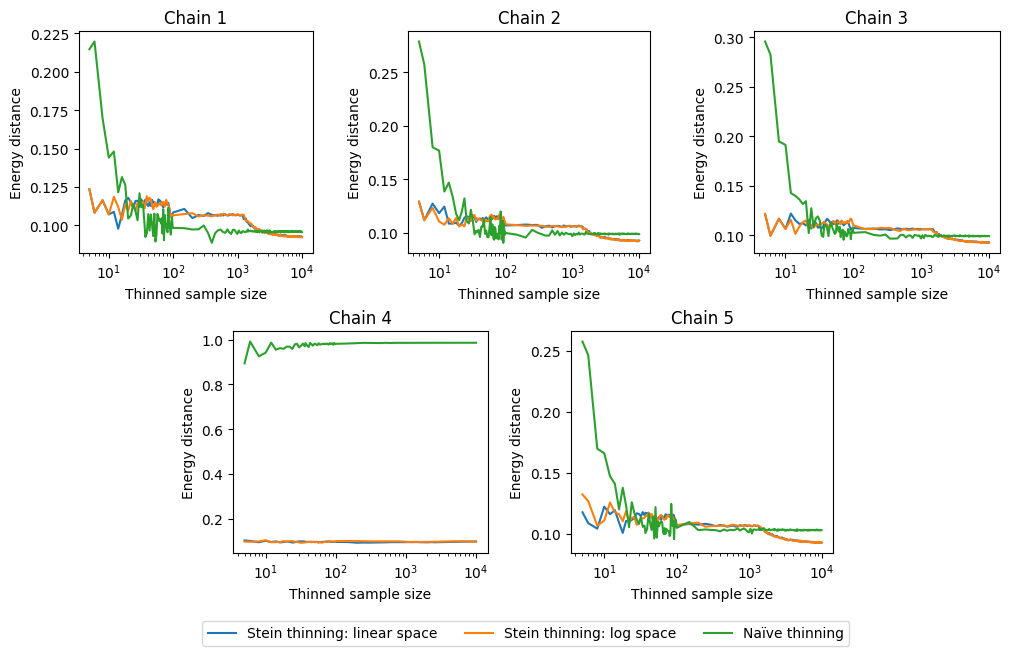

In [26]:
%%time
fig, axs = plot_comparison(get_indices, indices1, y_label='Energy distance')
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.52, -0.08), ncol=len(labels), bbox_transform=fig.transFigure);
fig.savefig(FIGURES_PATH / 'lotka-volterra-stein-thinning-energy-distance.pdf', bbox_inches='tight', metadata={'CreationDate': None});

In [27]:
@cached()
def rw_ksd(i_chain, idx_name) -> np.ndarray:
    sample = rw_samples[i_chain]
    gradient = rw_grads[i_chain]
    idx = globals()[idx_name][i_chain]
    distances = calculate_ksd(sample, gradient, idx)[thinned_sizes - 1]
    return np.stack([thinned_sizes, distances], axis=1)

In [28]:
@cached()
def rw_ksd_naive(i_chain) -> np.ndarray:
    sample = rw_samples[i_chain]
    gradient = rw_grads[i_chain]
    n = sample.shape[0]
    distances = np.fromiter(
        (calculate_ksd(sample, gradient, naive_idx(n, thinned_size))[-1] for thinned_size in thinned_sizes),
        float,
    )
    return np.stack([thinned_sizes, distances], axis=1)

In [29]:
def get_indices_ksd(name):
    if name == 'rw_naive':
        return rw_ksd_naive
    else:
        return lambda i: rw_ksd(i, name)

DEBUG:utils.caching:Reading from disk cache: rw_ksd_0_rw_thinned_idx
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_ksd_0_rw_thinned_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_ksd_0_rw_st_log_idx
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_ksd_0_rw_st_log_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_ksd_naive_0
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_ksd_naive_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_ksd_1_rw_thinned_idx
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_ksd_1_rw_thinned_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_ksd_1_rw_st_log_idx
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_ksd_1_rw_st_log_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_ksd_naive_1
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_ksd_naive_1.npy
DEBUG:utils.caching:Reading from disk 

CPU times: user 3.61 s, sys: 36.5 ms, total: 3.64 s
Wall time: 7.87 s


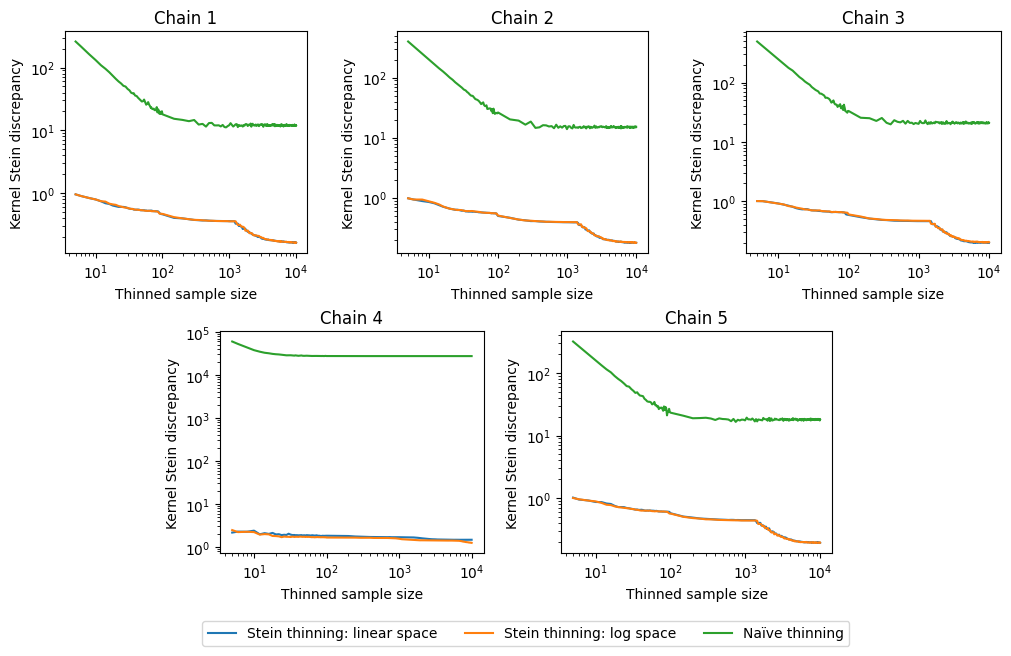

In [30]:
%%time
fig, axs = plot_comparison(get_indices_ksd, indices1, y_label='Kernel Stein discrepancy', y_scale='log')
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.52, -0.08), ncol=len(labels), bbox_transform=fig.transFigure);
fig.savefig(FIGURES_PATH / 'lotka-volterra-stein-thinning-ksd.pdf', bbox_inches='tight', metadata={'CreationDate': None});

In [31]:
indices2 = {
    'rw_naive': 'Naïve thinning',
    'rw_st_log_idx': 'Stein thinning',
    'rw_gf_simple_gaussian_idx': 'Gradient-free Stein thinning',
    #'rw_gf_adjusted_gaussian_idx': 'Gradient-free adjusted Gaussian',
    #'rw_gf_t_idx': 'Gradient-free: t optimised',
    #'rw_gf_t2_idx': 'Gradient-free: t fixed',
}

DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_0_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_energy_distance_0_rw_gf_simple_gaussian_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_1_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_energy_distance_1_rw_gf_simple_gaussian_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_2_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_energy_distance_2_rw_gf_simple_gaussian_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_3_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_energy_distance_3_rw_gf_simple_gaussian_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_4_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-p

CPU times: user 2.17 s, sys: 31.4 ms, total: 2.2 s
Wall time: 3.79 s


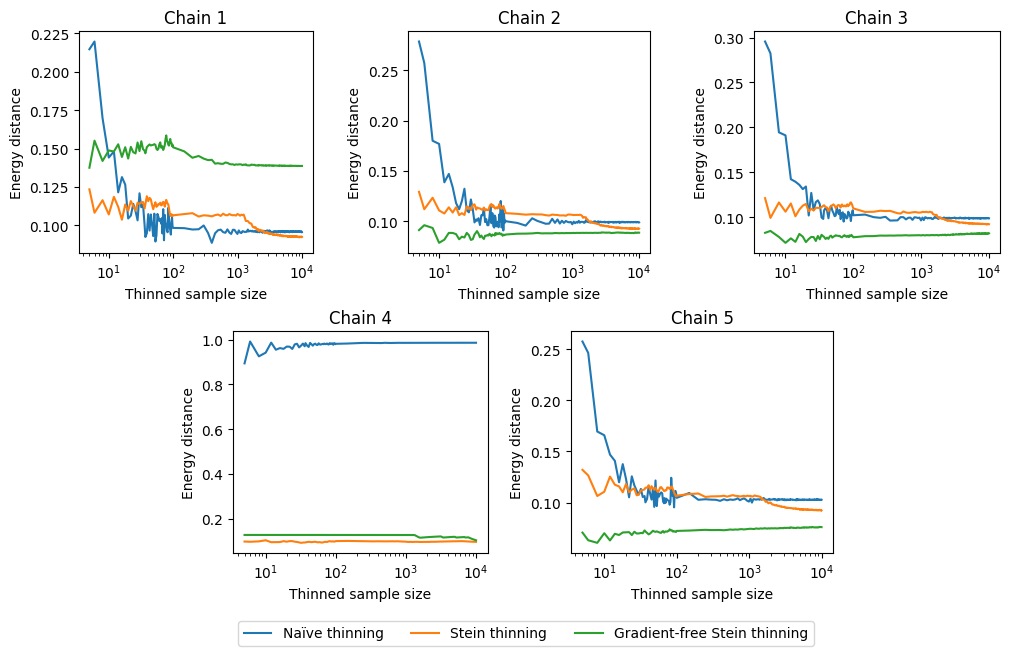

In [32]:
%%time
fig, axs = plot_comparison(get_indices, indices2, y_label='Energy distance')
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.52, -0.08), ncol=len(labels), bbox_transform=fig.transFigure);
fig.savefig(FIGURES_PATH / 'lotka-volterra-gf-thinning-energy-distance.pdf', bbox_inches='tight', metadata={'CreationDate': None});

DEBUG:utils.caching:Reading from disk cache: rw_ksd_0_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_ksd_0_rw_gf_simple_gaussian_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_ksd_1_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_ksd_1_rw_gf_simple_gaussian_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_ksd_2_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_ksd_2_rw_gf_simple_gaussian_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_ksd_3_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_ksd_3_rw_gf_simple_gaussian_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_ksd_4_rw_gf_simple_gaussian_idx
DEBUG:utils.caching:Reading from S3 gradient-free-mcmc-postprocessing/rw_ksd_4_rw_gf_simple_gaussian_idx.npy


CPU times: user 3.3 s, sys: 27.9 ms, total: 3.33 s
Wall time: 4.71 s


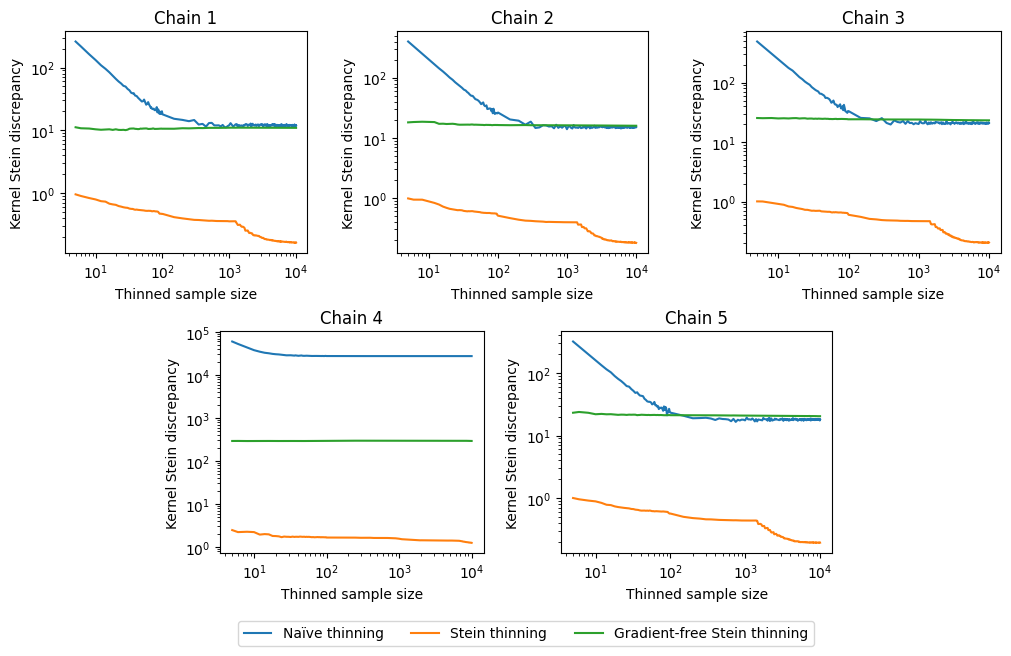

In [33]:
%%time
fig, axs = plot_comparison(get_indices_ksd, indices2, y_label='Kernel Stein discrepancy', y_scale='log')
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.52, -0.08), ncol=len(labels), bbox_transform=fig.transFigure);
fig.savefig(FIGURES_PATH / 'lotka-volterra-gf-thinning-ksd.pdf', bbox_inches='tight', metadata={'CreationDate': None});

Notebook execution took:

In [34]:
time.time() - start_time

53.9399847984314